<a href="https://colab.research.google.com/github/2j0123/WASSUP_Project_Team7_2/blob/JS/Drug_Data_EDA_Preprocess_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug Dataset Preprocess

In [1]:
import pandas as pd

In [2]:
drug_data = pd.read_csv('/home/kdt-admin/miniconda3/envs/JS/WASSUP_Project_Team7_2/drugsComTrain_raw.csv')

## 전처리

### 결측치 제거

In [3]:
drug_data = drug_data.dropna()
drug_data.isna().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

### 전처리 함수

#### 숫자와 영어 알파벳을 제외한 문자를 공백으로 대체

In [4]:
import re

def extract_word(text):
    non_english = re.compile('[^a-zA-Z0-9]')
    return non_english.sub(' ', text)

#### 소문자로 변환

In [5]:
def fix_lower(text):
    fixed_text = text.lower() # 소문자로 변환
    return fixed_text

#### 불용어 제거

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt') #token
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/kdt-admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kdt-
[nltk_data]     admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
english_stopwords = set(stopwords.words('english'))
english_stopwords.discard('no') # no를 불용어에 포함시키지 않음
english_stopwords.discard('not') # not를 불용어에 포함시키지 않음

def del_stopwords(tokens):
    return [token for token in tokens if token not in english_stopwords and token.isalnum()]

#### 숫자와 수치형 단위 제거

In [8]:
def del_numericalunits(text):
    non_numericalunits = r'\b\d+(\.\d+)?\s?\S*' # 숫자와 단위 정규 표현식
    return re.sub(non_numericalunits, '', text)

#### Lemmatization


In [9]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

def fix_lemmatization(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

[nltk_data] Downloading package wordnet to /home/kdt-
[nltk_data]     admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kdt-admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### 토큰화

In [10]:
from nltk.tokenize import word_tokenize

def fix_tokenize(text):
    return word_tokenize(text)

#### 공백 수정 및 토큰 연결

In [11]:
def join_tokens(tokens):
    return ' '.join(tokens) # 공백으로 연결

#### 공백 제거

In [12]:
def del_space(text):
    return text.replace(" ", "")

#### html 코드 제거

In [13]:
# from bs4 import BeautifulSoup

def del_html(text):
    # return BeautifulSoup(text, 'html.parser').get_text() # </span>만 제거되고 문장은 제거되지 않음.
    if '</span> users found this comment helpful.' in text:
        return ''
    else:
        return text

#### apostrophe 제거

In [14]:
def remove_apostrophe(text):
    return text.replace("'", "")

#### Stemming

In [15]:
from nltk.stem import PorterStemmer, LancasterStemmer

porter_stemmer = PorterStemmer()

lancaster_stemmer = LancasterStemmer()

##### Porter Stemming 

In [16]:
def porter_stemming(review):
    return [porter_stemmer.stem(word) for word in review]

##### Lancaster stemming

In [17]:
def lancaster_stemming(review):
    return [lancaster_stemmer.stem(word) for word in review]

#### Padding

In [18]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

2024-04-07 21:17:12.059370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 21:17:13.164410: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##### Padding 적용 함수

In [19]:
def convert_padding(df, column_name):
    tokenizer.fit_on_texts(df[column_name])
    sequences = tokenizer.texts_to_sequences(df[column_name])
    max_length = max(len(sentence) for sentence in df[column_name]) # 최대 문장 길이
    padded_review = pad_sequences(sequences, maxlen=max_length, padding='post') # Padding
    
    return padded_review.tolist()

#### Embedding

In [20]:
import numpy as np

embedding_index = {}
with open('glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [21]:
#def convert_embedding(df, column_name):
#    embedded_sequences = []
    
#    for sequence in df[column_name]:
#        embedded_sequence = []
#        for word_index in sequence:
#            if word_index != 0:  # 패딩된 값(0)인 경우 무시
#                word = tokenizer.index_word[word_index]
#                embedding_vector = embedding_index.get(word)
#                if embedding_vector is not None:
#                    embedded_sequence.append(embedding_vector)
#        embedded_sequences.append(embedded_sequence)
#    
#    return np.array(embedded_sequences)

In [22]:
def convert_embedding(sentence):
    embedded_sentence = []
    for word in sentence:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedded_sentence.append(embedding_vector)
    return np.array(embedded_sentence)

### 'review' 전처리

#### 'review' 전처리 통합 함수


In [23]:
def preprocess_review(text):
    fixed_text = del_html(text) # html 코드 제거
    fixed_text = remove_apostrophe(fixed_text) # apostrophe 제거
    fixed_text = extract_word(text) # 숫자와 영어 알파벳을 제외한 문자를 공백으로 대체
    fixed_text = fix_lower(fixed_text) # 소문자로 변환
    fixed_text = del_numericalunits(fixed_text) # 숫자와 수치형 단위 제거
    tokens = fix_tokenize(fixed_text) # 토큰화
    filtered_tokens = del_stopwords(tokens) # 불용어 제거
    lemmatized_tokens = fix_lemmatization(filtered_tokens) # Lemmatization
    fixed_text = join_tokens(lemmatized_tokens) # 공백 수정 및 토큰 연결
    return fixed_text.split()

#### 'review' 컬럼 전처리 통합 함수 적용


In [24]:
drug_data['fixed_review'] = drug_data['review'].apply(preprocess_review)

In [25]:
drug_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,fixed_review
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"[no, side, effect, take, combination, bystolic..."
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"[son, halfway, fourth, week, intuniv, became, ..."
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"[used, take, another, oral, contraceptive, cyc..."
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"[first, time, using, form, birth, control, gla..."
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"[suboxone, completely, turned, life, around, f..."


#### 'review' 컬럼 Stemming 적용

In [26]:
#drug_data['fixed_review'] = drug_data['fixed_review'].apply(lancaster_stemming)
drug_data['fixed_review'] = drug_data['fixed_review'].apply(porter_stemming)

In [27]:
print("stemming result length : ", len(set(word for review in drug_data['fixed_review'] for word in review)))

stemming result length :  32625


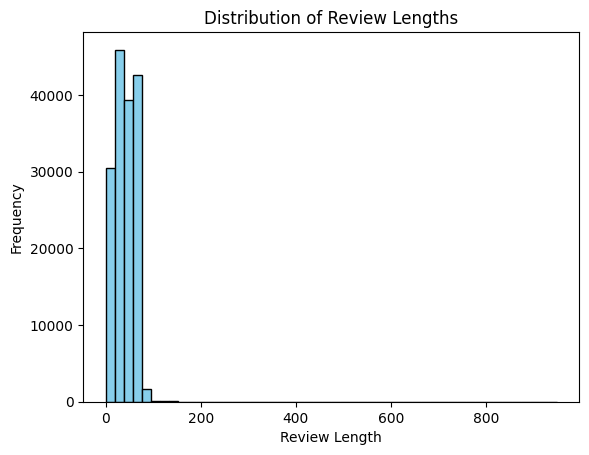

In [28]:
import matplotlib.pyplot as plt

# 'fixed_review' 열의 각 리뷰의 길이 계산
review_lengths = drug_data['fixed_review'].apply(len)

# 히스토그램으로 리뷰의 길이 분포 시각화
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

In [29]:
# 'fixed_review' 열에서 가장 긴 리뷰의 길이를 찾습니다.
max_length = review_lengths.max()

# 가장 긴 리뷰의 길이를 출력합니다.
print("The length of the longest review:", max_length)

The length of the longest review: 949


In [30]:
# 'fixed_review' 열에서 각 리뷰의 길이 계산
review_lengths = drug_data['fixed_review'].apply(len)

# 리뷰의 길이가 200자 이상인 인덱스를 찾습니다.
long_reviews_index = review_lengths[review_lengths >= 200].index

# 리뷰의 길이가 200자 이상인 리뷰의 개수를 세기
long_reviews_count = (review_lengths >= 200).sum()

# 결과 출력
print("Number of reviews with length >= 200:", long_reviews_count)

# 해당 인덱스를 사용하여 데이터프레임에서 해당 행을 삭제합니다.
drug_data = drug_data.drop(long_reviews_index)

# 삭제 후의 데이터프레임 정보 출력
print("Number of rows after removing long reviews:", len(drug_data))

Number of reviews with length >= 200: 51
Number of rows after removing long reviews: 160347


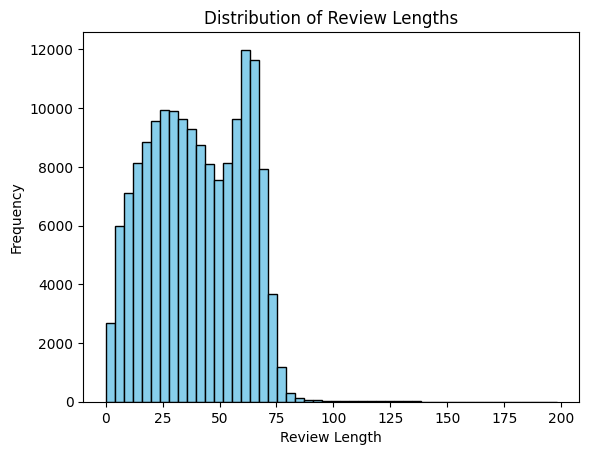

In [31]:
import matplotlib.pyplot as plt

# 'fixed_review' 열의 각 리뷰의 길이 계산
review_lengths = drug_data['fixed_review'].apply(len)


# 히스토그램으로 리뷰의 길이 분포 시각화
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

In [32]:
# 'fixed_review' 열에서 각 리뷰의 길이 계산
review_lengths = drug_data['fixed_review'].apply(len)

# 리뷰의 길이가 100자 이상인 리뷰의 개수를 세기
long_reviews_count = (review_lengths >= 100).sum()

# 전체 리뷰의 개수
total_reviews_count = len(drug_data)

# 결과 출력
print("Number of reviews with length >= 200:", long_reviews_count)
print("Total number of reviews:", total_reviews_count)

Number of reviews with length >= 200: 183
Total number of reviews: 160347


In [33]:
# 리뷰의 길이가 100 이상인 인덱스를 찾습니다.
long_reviews_index = review_lengths[review_lengths >= 100].index

# 해당 인덱스를 사용하여 데이터프레임에서 해당 행을 삭제합니다.
drug_data = drug_data.drop(long_reviews_index)

# 삭제 후의 데이터프레임 정보 출력
print("Number of rows after removing long reviews:", len(drug_data))

Number of rows after removing long reviews: 160164


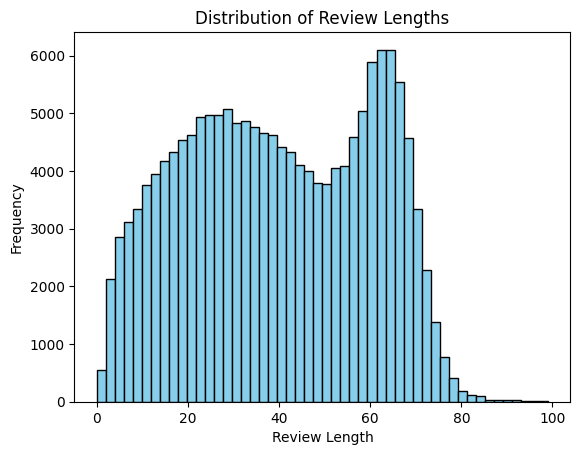

In [34]:
import matplotlib.pyplot as plt

# 'fixed_review' 열의 각 리뷰의 길이 계산
review_lengths = drug_data['fixed_review'].apply(len)

# 히스토그램으로 리뷰의 길이 분포 시각화
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.show()

#### 'review' 컬럼 Padding 적용

In [35]:
#drug_data['fixed_review'] = convert_padding(drug_data, 'fixed_review')

In [36]:
#drug_data.head()

In [37]:
#print(drug_data['fixed_review'][0])
#print(len(drug_data['fixed_review'][0]))

#### 'review' 컬럼 Embedding 적용

In [38]:
#drug_data['fixed_review'] = convert_embedding(drug_data, 'fixed_review')

In [39]:
#drug_data.head()

### 'condition', 'drugName' 이상치 처리

In [40]:
drug_data = drug_data[~drug_data['condition'].str.match('\d{2}-[a-zA-Z]{3}-\d{2}', na=False)]
drug_data = drug_data[~drug_data['drugName'].str.match('\d+', na=False)]

### 'condition' 전처리

#### 'condition' 전처리 통합 함수

In [41]:
def preprocess_condition(text):
    fixed_text = del_html(text) # html 코드 제거
    #fixed_text = del_space(fixed_text) # 공백 제거
    fixed_text = remove_apostrophe(fixed_text) # apostrophe 제거
    fixed_text = extract_word(fixed_text) # 숫자와 영어 알파벳을 제외한 문자를 공백으로 대체
    fixed_text = fix_lower(fixed_text) # 소문자로 변환
    tokens = fix_tokenize(fixed_text) # 토큰화
    fixed_text = join_tokens(tokens) # 공백 수정 및 토큰 연결
    return fixed_text.split()

#### 'condition' 전처리 통합 함수 적용

In [42]:
drug_data['fixed_condition'] = drug_data['condition'].apply(preprocess_condition)

In [43]:
drug_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,fixed_review,fixed_condition
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"[no, side, effect, take, combin, bystol, fish,...","[left, ventricular, dysfunction]"
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"[son, halfway, fourth, week, intuniv, becam, c...",[adhd]
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"[use, take, anoth, oral, contracept, cycl, hap...","[birth, control]"
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"[first, time, use, form, birth, control, glad,...","[birth, control]"
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"[suboxon, complet, turn, life, around, feel, h...","[opiate, dependence]"


#### 'condition' 컬럼 Stemming 적용

In [44]:
drug_data['fixed_condition'] = drug_data['fixed_condition'].apply(porter_stemming)

In [45]:
print("stemming result length : ", len(set(word for review in drug_data['fixed_condition'] for word in review)))

stemming result length :  975


#### 'condition' 컬럼 Padding 적용

In [46]:
#drug_data['fixed_condition'] = convert_padding(drug_data, 'fixed_condition')

In [47]:
#drug_data.head()

#### 'condition' 컬럼 Embedding 적용

In [48]:
#drug_data['fixed_condition'] = convert_embedding(drug_data, 'fixed_condition')

In [49]:
#drug_data.head()

### 'Combined_re_con' 생성

#### fixed_condition'와 'fixed_review' 컬럼이 모두 비어 있는 리스트 행 개수

In [50]:
#empty_both_rows = (drug_data['fixed_condition'].apply(len) == 0) & (drug_data['fixed_review'].apply(len) == 0)
#empty_both_count = empty_both_rows.sum()

#print("Counts of 'fixed_condition', 'fixed_review' is Empty :", empty_both_count)

#### fixed_condition'와 'fixed_review' 컬럼이 모두 비어 있는 리스트 행 제거

In [51]:
#print("Before Delete Dataset Size :", drug_data.shape)

#drug_data = drug_data[~((drug_data['fixed_condition'].apply(len) == 0) & (drug_data['fixed_review'].apply(len) == 0))]

#print("After Delete Dataset Size  :", drug_data.shape)

In [52]:
#drug_data.head()

#### 'fixed_review' , 'fixed_condition' 결합

In [53]:
drug_data['Combined_re_con'] = drug_data['fixed_review'] + drug_data['fixed_condition']

In [54]:
drug_data['Combined_re_con'].head()

0    [no, side, effect, take, combin, bystol, fish,...
1    [son, halfway, fourth, week, intuniv, becam, c...
2    [use, take, anoth, oral, contracept, cycl, hap...
3    [first, time, use, form, birth, control, glad,...
4    [suboxon, complet, turn, life, around, feel, h...
Name: Combined_re_con, dtype: object

In [55]:
max_length = drug_data['Combined_re_con'].apply(len).max()

print("Max length:", max_length)

Max length: 101


#### 'Combined_re_con' 컬럼 등장 빈도 3회 미만 단어

In [56]:
from collections import Counter

words = []
for text in drug_data['Combined_re_con']:
    words.extend(text)

word_freq = Counter(words)

words_to_remove = {word for word, freq in word_freq.items() if freq < 3} # 등장 빈도 3회 미만 단어

print("총 단어:", len(set(words)))

print("등장 빈도가 3회 미만인 단어 :", len(words_to_remove))

총 단어: 32647
등장 빈도가 3회 미만인 단어 : 16568


#### 'Combined_re_con' 등장 빈도 3회 미만 단어 제거

In [57]:
drug_data['Combined_re_con'] = drug_data['Combined_re_con'].apply(
    lambda text_list: [word for word in text_list if word not in words_to_remove]
)

words = []
for text in drug_data['Combined_re_con']: # 제거 후 총 단어 개수 
    words.extend(text)

print("총 단어:", len(set(words)))

총 단어: 16079


In [58]:
drug_data['Combined_re_con'].isnull().sum()

0

In [59]:
drug_data['Combined_re_con'].head()

0    [no, side, effect, take, combin, bystol, fish,...
1    [son, halfway, fourth, week, intuniv, becam, c...
2    [use, take, anoth, oral, contracept, cycl, hap...
3    [first, time, use, form, birth, control, glad,...
4    [suboxon, complet, turn, life, around, feel, h...
Name: Combined_re_con, dtype: object

#### 'Combined_re_con' Padding 적용

In [60]:
type(drug_data['Combined_re_con'])

pandas.core.series.Series

In [61]:
drug_data['Padding_re_con'] = convert_padding(drug_data, 'Combined_re_con')

In [62]:
print("MAX :", max([max(row) for row in drug_data['Padding_re_con']]))

MAX : 16079


#### 'Combined_re_con' Embedding 적용

In [63]:
#drug_data['Embedding_re_con'] = convert_embedding(drug_data, 'Padding_re_con')

In [64]:
drug_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,fixed_review,fixed_condition,Combined_re_con,Padding_re_con
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"[no, side, effect, take, combin, bystol, fish,...","[left, ventricular, dysfunct]","[no, side, effect, take, combin, bystol, fish,...","[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649..."
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"[son, halfway, fourth, week, intuniv, becam, c...",[adhd],"[son, halfway, fourth, week, intuniv, becam, c...","[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,..."
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"[use, take, anoth, oral, contracept, cycl, hap...","[birth, control]","[use, take, anoth, oral, contracept, cycl, hap...","[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457..."
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"[first, time, use, form, birth, control, glad,...","[birth, control]","[first, time, use, form, birth, control, glad,...","[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35..."
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"[suboxon, complet, turn, life, around, feel, h...","[opiat, depend]","[suboxon, complet, turn, life, around, feel, h...","[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1..."


### 'drugName' 인코딩

#### 'drugName' Label Encoding

In [65]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 초기화
label_encoder = LabelEncoder()

drug_data['encoded_drugName'] = label_encoder.fit_transform(drug_data['drugName'])

print(drug_data[['drugName', 'encoded_drugName']])

                        drugName  encoded_drugName
0                      Valsartan              3197
1                     Guanfacine              1428
2                         Lybrel              1851
3                     Ortho Evra              2279
4       Buprenorphine / naloxone               515
...                          ...               ...
161292                   Campral               554
161293            Metoclopramide              1971
161294                   Orencia              2273
161295        Thyroid desiccated              3022
161296              Lubiprostone              1837

[160164 rows x 2 columns]


#### 'drugName' Label Encoding MAX number

In [66]:
print("MAX Number :", drug_data['encoded_drugName'].max())

MAX Number : 3429


In [67]:
drug_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,fixed_review,fixed_condition,Combined_re_con,Padding_re_con,encoded_drugName
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"[no, side, effect, take, combin, bystol, fish,...","[left, ventricular, dysfunct]","[no, side, effect, take, combin, bystol, fish,...","[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"[son, halfway, fourth, week, intuniv, becam, c...",[adhd],"[son, halfway, fourth, week, intuniv, becam, c...","[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"[use, take, anoth, oral, contracept, cycl, hap...","[birth, control]","[use, take, anoth, oral, contracept, cycl, hap...","[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"[first, time, use, form, birth, control, glad,...","[birth, control]","[first, time, use, form, birth, control, glad,...","[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"[suboxon, complet, turn, life, around, feel, h...","[opiat, depend]","[suboxon, complet, turn, life, around, feel, h...","[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515


### 파생변수 'sentiment' 생성

#### rating(평점)이 8 이상이면 1(긍정), 5이상 7이하이면 2(보통), 1이상 4이하이면 3(부정)
// describe()를 근거로 하지만 75% 가 10이기 때문에 위배될 가능성

In [68]:
drug_data['sentiment'] = drug_data['rating'].apply(lambda x: 1 if x >= 8 else (2 if x >= 5 else 3))

In [69]:
drug_data.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,fixed_review,fixed_condition,Combined_re_con,Padding_re_con,encoded_drugName,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"[no, side, effect, take, combin, bystol, fish,...","[left, ventricular, dysfunct]","[no, side, effect, take, combin, bystol, fish,...","[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"[son, halfway, fourth, week, intuniv, becam, c...",[adhd],"[son, halfway, fourth, week, intuniv, becam, c...","[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"[use, take, anoth, oral, contracept, cycl, hap...","[birth, control]","[use, take, anoth, oral, contracept, cycl, hap...","[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851,2
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"[first, time, use, form, birth, control, glad,...","[birth, control]","[first, time, use, form, birth, control, glad,...","[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"[suboxon, complet, turn, life, around, feel, h...","[opiat, depend]","[suboxon, complet, turn, life, around, feel, h...","[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515,1
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,"[day, start, work, rock, hard, erect, howev, e...","[benign, prostat, hyperplasia]","[day, start, work, rock, hard, erect, howev, e...","[3, 9, 6, 1675, 252, 865, 120, 9166, 72, 261, ...",668,3
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5,"[pull, cum, bit, took, plan, b, later, took, p...","[emerg, contracept]","[pull, cum, bit, took, plan, b, later, took, p...","[895, 3019, 195, 35, 284, 416, 148, 35, 320, 3...",1745,3
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32,"[abilifi, chang, life, hope, zoloft, clonidin,...","[bipolar, disord]","[abilifi, chang, life, hope, zoloft, clonidin,...","[807, 77, 37, 92, 356, 1797, 15, 9, 807, 433, ...",259,1
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11,"[noth, problem, keppera, constant, shake, arm,...",[epilepsi],"[noth, problem, keppera, constant, shake, arm,...","[100, 75, 10101, 333, 731, 379, 94, 242, 94, 2...",1659,3
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1,"[pill, mani, year, doctor, chang, rx, chateal,...","[birth, control]","[pill, mani, year, doctor, chang, rx, chateal,...","[21, 133, 26, 32, 77, 1392, 2755, 4, 43, 24, 1...",1179,1


### 'fixed_date' 생성

#### 'date' 컬럼 'datetime' 형식으로 변환

In [70]:
drug_data['fixed_date'] = pd.to_datetime(drug_data['date'])

/tmp/ipykernel_255168/4049783553.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  drug_data['fixed_date'] = pd.to_datetime(drug_data['date'])


In [71]:
drug_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,fixed_review,fixed_condition,Combined_re_con,Padding_re_con,encoded_drugName,sentiment,fixed_date
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"[no, side, effect, take, combin, bystol, fish,...","[left, ventricular, dysfunct]","[no, side, effect, take, combin, bystol, fish,...","[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197,1,2012-05-20
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"[son, halfway, fourth, week, intuniv, becam, c...",[adhd],"[son, halfway, fourth, week, intuniv, becam, c...","[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428,1,2010-04-27
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"[use, take, anoth, oral, contracept, cycl, hap...","[birth, control]","[use, take, anoth, oral, contracept, cycl, hap...","[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851,2,2009-12-14
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"[first, time, use, form, birth, control, glad,...","[birth, control]","[first, time, use, form, birth, control, glad,...","[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279,1,2015-11-03
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"[suboxon, complet, turn, life, around, feel, h...","[opiat, depend]","[suboxon, complet, turn, life, around, feel, h...","[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515,1,2016-11-27


## 모델링에 불필요한 컬럼 제거 후 새로운 데이터 프레임 생성

In [72]:
drug_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,fixed_review,fixed_condition,Combined_re_con,Padding_re_con,encoded_drugName,sentiment,fixed_date
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"[no, side, effect, take, combin, bystol, fish,...","[left, ventricular, dysfunct]","[no, side, effect, take, combin, bystol, fish,...","[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197,1,2012-05-20
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"[son, halfway, fourth, week, intuniv, becam, c...",[adhd],"[son, halfway, fourth, week, intuniv, becam, c...","[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428,1,2010-04-27
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"[use, take, anoth, oral, contracept, cycl, hap...","[birth, control]","[use, take, anoth, oral, contracept, cycl, hap...","[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851,2,2009-12-14
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"[first, time, use, form, birth, control, glad,...","[birth, control]","[first, time, use, form, birth, control, glad,...","[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279,1,2015-11-03
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"[suboxon, complet, turn, life, around, feel, h...","[opiat, depend]","[suboxon, complet, turn, life, around, feel, h...","[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515,1,2016-11-27


### 전처리가 끝난 데이터셋 백업

In [73]:
drug_data_after_preprocess = drug_data

In [74]:
#drug_data_after_preprocess.to_csv('drug_data_after_preprocess.csv', index=True)

### 모델링을 위한 불필요한 컬럼 제거

In [75]:
#drug_data_for_modeling = drug_data.drop(columns=['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'sentiment', 'fixed_date'])
drug_data_for_modeling = drug_data[['Combined_re_con', 'encoded_drugName']].copy()

### 모델링을 위한 불필요한 컬럼이 제거된 데이터셋 백업

In [76]:
drug_data_for_modeling.to_csv('drug_data_for_modeling.csv', index=False)

In [77]:
drug_data_for_modeling.head()

,Combined_re_con,encoded_drugName
0,"[no, side, effect, take, combin, bystol, fish,...",3197
1,"[son, halfway, fourth, week, intuniv, becam, c...",1428
2,"[use, take, anoth, oral, contracept, cycl, hap...",1851
3,"[first, time, use, form, birth, control, glad,...",2279
4,"[suboxon, complet, turn, life, around, feel, h...",515


In [80]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_embedded = []
for sentence in drug_data_for_modeling['Combined_re_con']:
    embedded_sentence = convert_embedding(sentence)
    X_embedded.append(embedded_sentence)

MAX_SEQUENCE_LENGTH = max(len(seq) for seq in X_embedded)
X_padded = pad_sequences(X_embedded, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print("패딩된 시퀀스의 크기:", X_padded.shape)

패딩된 시퀀스의 크기: (160164, 89, 50)


In [81]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

EMBEDDING_DIM = 50
NUM_CLASSES = drug_data_for_modeling['encoded_drugName'].nunique()

X = X_padded
y = drug_data_for_modeling['encoded_drugName']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#model = Sequential([
#    LSTM(64, input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)), 
#    Dense(NUM_CLASSES, activation='softmax')
#])

#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

#loss, accuracy = model.evaluate(X_val, y_val)

In [82]:
drug_data_for_h20 = drug_data[['Padding_re_con', 'encoded_drugName']].copy()

In [1]:
drug_data_for_h20.to_csv('drug_data_for_h20.csv', index=False)

In [84]:
drug_data_for_h20.head()

,Padding_re_con,encoded_drugName
0,"[7, 10, 4, 1, 494, 2198, 2492, 1197, 312, 3649...",3197
1,"[493, 2555, 1336, 19, 2455, 303, 614, 257, 48,...",1428
2,"[17, 1, 172, 885, 370, 359, 159, 190, 20, 1457...",1851
3,"[15, 13, 17, 475, 14, 12, 469, 50, 278, 15, 35...",2279
4,"[746, 134, 376, 37, 137, 11, 1808, 888, 338, 1...",515
